In [8]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import f90nml

In [9]:
# read the namelist

nml = f90nml.read('my_thermo.in')
print(nml)

&params
    k_z_min = 1e-06
    k_z_max = 2.0
    n_k_z = 2500
    log_k_z = .true.
    rescale_k_z_min = .true.
    rescale_k_z_max = .true.
    n = 17
    r0 = 188956028554864.66
    pr = 1.6239210035454995e-10
    tau = 5.2868944831444755e-15
    w_f = 1e-10
    h_b = 6.8108821736170655e-09
    d_b = 1.6038348194634774e-09
    split = .true.
    nev = 10
    out_file = 'thermo.h5'
/


In [10]:
def read_thermo(filename):

    with h5py.File(filename, 'r') as f:

        eigs = f['sig']['re'][...] + 1j*f['sig']['im'][...]
        k_z = f['k_z'][...]

        lam_f = f.attrs['lam_f']
        l_f = f.attrs['l_f']

        eigs_max_la = f['sig_max_la']['re'][...] + 1j * f['sig_max_la']['im'][...]
        eigs_max_ar = f['sig_max_ar']['re'][...] + 1j * f['sig_max_ar']['im'][...]
        ar_success = f['ar_sucess'][...]

        la_time = f['la_time'][...]
        ar_time = f['ar_time'][...]

    return np.transpose(eigs)/lam_f, k_z/l_f, eigs_max_la/lam_f, eigs_max_ar/lam_f, ar_success, la_time, ar_time

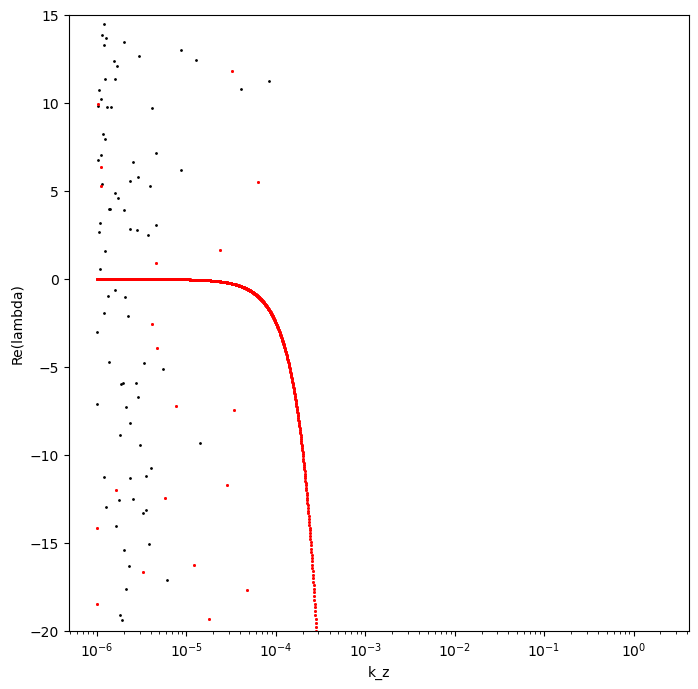

In [11]:
# Read data

eigs, k_z, eigs_max_la, eigs_max_ar, ar_success, la_time, ar_time = read_thermo('thermo.h5')

# Plot the results

plt.figure(figsize=[8,8])

d = eigs.shape[0]

for j in range(d):
    i = np.where(np.abs(eigs[j,:].imag) > 1e-12)[0]
    if len(i) > 1:
        plt.scatter(k_z[i], eigs[j,i].real, 1, color='r')
    i = np.where(np.abs(eigs[j,:].imag) < 1e-12)[0]
    if len(i) > 1:
        plt.scatter(k_z[i], eigs[j,i].real, 1, color='k')

# fail_ind = np.argmin(ar_success)
# print(f'ARPACK failed at index {fail_ind}')

# plt.vlines(k_z[1294], -20, 5)
plt.xlabel('k_z')
plt.ylabel('Re(lambda)')
plt.ylim(-20, 15)
# plt.ylim(3, 3.035)
plt.xscale('log')
# plt.xlim(.000325, .0005)

Text(0.5, 1.0, 'NEV = 10')

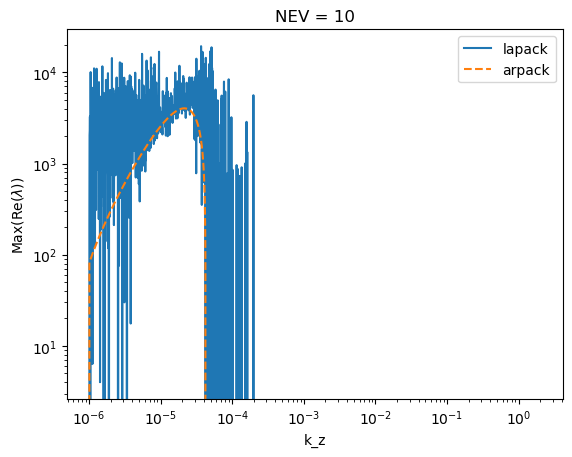

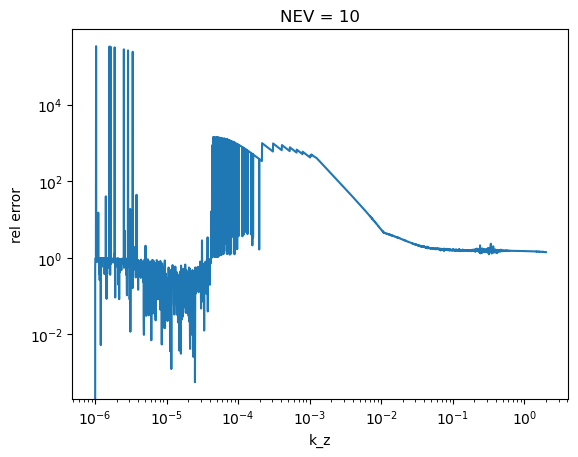

In [12]:
# Compare the LAPACK and ARPACK results for max e-value

plt.figure()
plt.plot(k_z, eigs_max_la.real, label='lapack')
plt.plot(k_z, eigs_max_ar.real, '--', label='arpack')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k_z')
plt.ylabel(r'Max(Re($\lambda$))')
plt.title('NEV = {}'.format(nml['params']['NEV']))
plt.legend()

plt.figure()
plt.plot(k_z, np.abs(eigs_max_ar.real - eigs_max_la.real) / np.abs(eigs_max_la.real))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k_z')
plt.ylabel('rel error')
plt.title('NEV = {}'.format(nml['params']['NEV']))

Text(0.5, 1.0, 'N = 17, NEV = 10')

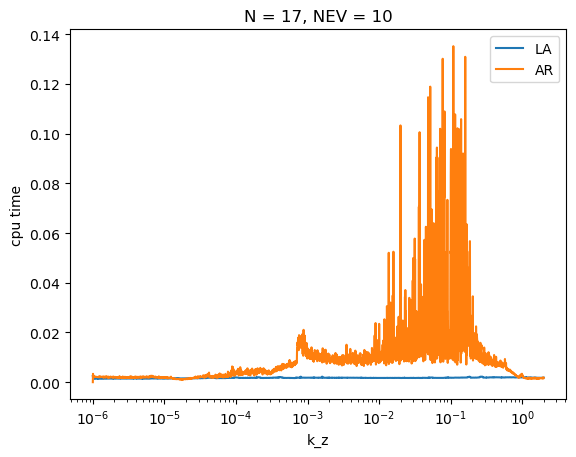

In [7]:
plt.figure()

plt.plot(k_z, la_time, label='LA')
plt.plot(k_z, ar_time, label='AR')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k_z')
plt.ylabel('cpu time')
plt.legend()
plt.title('N = {}, NEV = {}'.format(nml['params']['N'], nml['params']['NEV']))

Text(0.5, 0.98, 'Value tweaked: $D_B = 10^{-2}$')

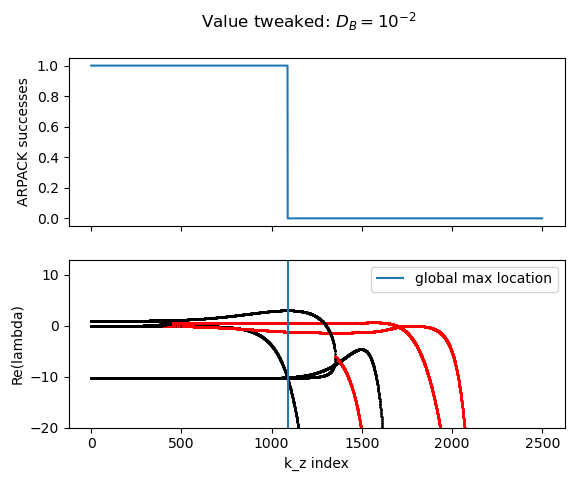

In [116]:
x = np.arange(k_z.size)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(x, ar_success)
ax1.set_ylabel('ARPACK successes')

for j in range(d):
    i = np.where(np.abs(eigs[j,:].imag) > 1e-12)[0]
    if len(i) > 1:
        ax2.scatter(x[i], eigs[j,i].real, 1, color='r')
    i = np.where(np.abs(eigs[j,:].imag) < 1e-12)[0]
    if len(i) > 1:
        ax2.scatter(x[i], eigs[j,i].real, 1, color='k')

global_max_loc = np.argmax(np.max(eigs.real, axis=0))

ylim = (-20, 13)
ax2.vlines(global_max_loc, *ylim, label='global max location')
ax2.set_xlabel('k_z index')
ax2.set_ylabel('Re(lambda)')
ax2.set_ylim(ylim)
# plt.ylim(3, 3.035)
# ax2.xscale('log')
# plt.xlim(.000325, .0005)
ax2.legend()
fig.suptitle(r'Value tweaked: $D_B = 10^{-2}$')

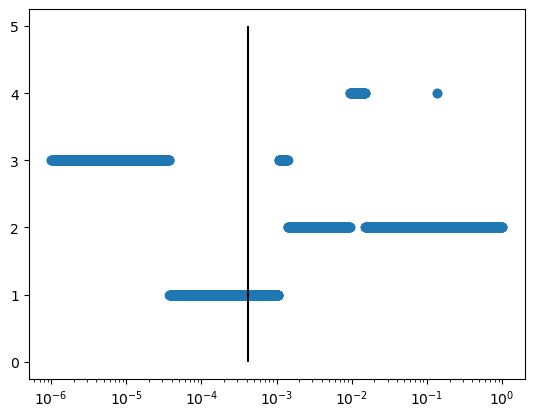

In [47]:
# plot how many e-vals are within some distance of the largest real
edist = 1

num_evals = np.zeros(eigs.shape[1], dtype=int)

# now count the number of evals within a given distance of the max
for i in range(num_evals.size):
    max_eval = np.max(eigs.real[:,i])
    num_evals[i] = np.sum(eigs.real[:,i] > (max_eval - edist) )
    # sorted_evals = np.sort(eigs.real[:,i])
    # avg_dist = (sorted_evals[-1] - sorted_evals[0]) / (sorted_evals.size - 1)

    # num_evals[i] = np.sum(sorted_evals > sorted_evals[-1] - avg_dist)


plt.figure()
plt.scatter(k_z, num_evals)
plt.xscale('log')
plt.vlines(k_z[1090], 0, 5, color='k')

(0.000325, 0.0005)

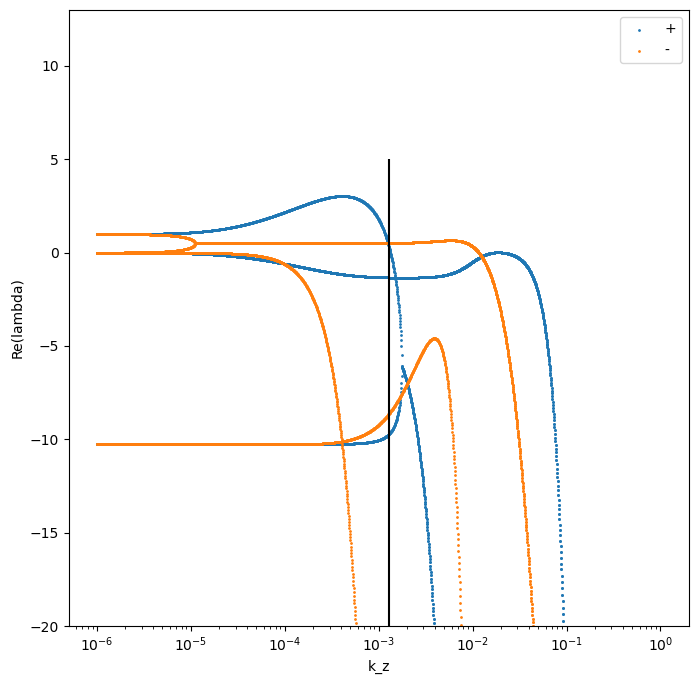

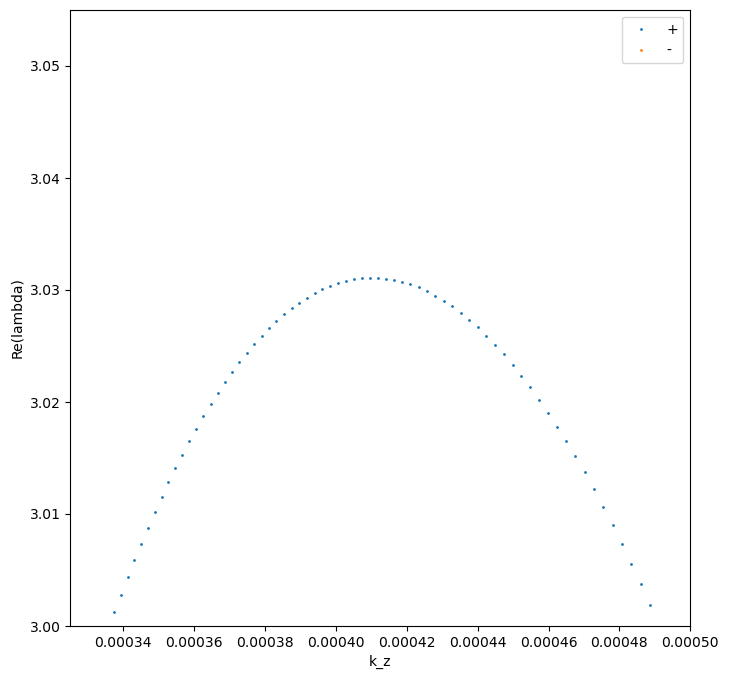

In [123]:
plt.figure(figsize=[8,8])

d = eigs.shape[0]

k_z_matrix = np.tile(k_z, (d, 1)) # duplicates k_z down rows (i.e values constant along cols)

p_slice = slice(0, d, 2)
m_slice = slice(1, d, 2)

plt.scatter(k_z_matrix[p_slice,:], eigs[p_slice,:], 1, label='+')
plt.scatter(k_z_matrix[m_slice,:], eigs[m_slice,:], 1, label='-')

plt.legend()
plt.vlines(k_z[fail_ind], -20, 5, color='k')
plt.xlabel('k_z')
plt.ylabel('Re(lambda)')
plt.ylim(-20, 13)
# plt.ylim(3, 3.035)
plt.xscale('log')
# plt.xlim(.000325, .0005)

plt.figure(figsize=[8,8])
plt.scatter(k_z_matrix[p_slice,:], eigs[p_slice,:], 1, label='+')
plt.scatter(k_z_matrix[m_slice,:], eigs[m_slice,:], 1, label='-')

plt.legend()
plt.vlines(k_z[fail_ind], -20, 5, color='k')
plt.xlabel('k_z')
plt.ylabel('Re(lambda)')
plt.ylim(3, 3.055)
plt.xlim(.000325, .0005)

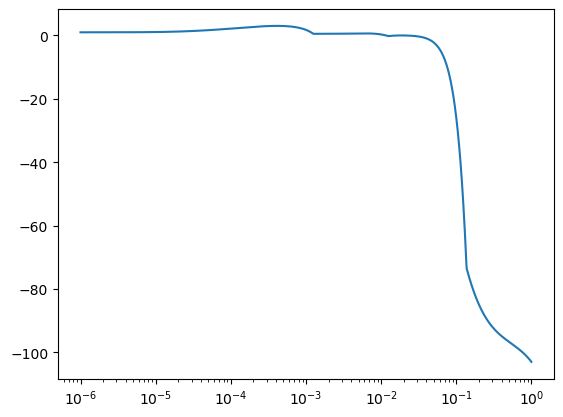

In [4]:
maxlocs = np.argmax(eigs.real, axis=0)
maxabs_locs = np.argmax(np.abs(eigs), axis=0)

# eps = 1

# mask = eigs.real > eigs.real.max(axis=0) - eps

# print(mask[:,0].sum())

eigs_sorted = np.sort(eigs.real, axis=0)

# print(eigs_sorted[-1,:] / eigs_sorted[-10,:])

plt.figure()
plt.plot(k_z, eigs_sorted[-1,:])
# plt.plot(k_z, eigs_sorted[-6,:], '--')
# plt.plot(k_z, eigs_sorted[0,:], '-.')
# plt.plot(k_z, eigs[maxabs_locs, range(eigs.shape[1])].real, '--')
plt.xscale('log')
# plt.ylim(-20, 5)
# plt.yscale('log')